In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
df = pd.read_csv("cadairydata.csv", index_col=None)
df.head()

,Unnamed: 0,Year.Month,Month.Number,Year,Month,Cotagecheese.Prod,Icecream.Prod,Milk.Prod,N.CA.Fat.Price
0,1,1995.01,1,1995,Jan,4.370,51.595,2.112,0.9803
1,2,1995.02,2,1995,Feb,3.695,56.086,1.932,0.8924
2,3,1995.03,3,1995,Mar,4.538,68.453,2.162,0.8924
3,4,1995.04,4,1995,Apr,4.280,65.722,2.130,0.8967
4,5,1995.05,5,1995,May,4.470,73.730,2.227,0.8967


Perform the following steps:

- Data is sorted in asecending order of year and month.
- A datetime object is created. 
- Some unnecessary columns are removed from the data frame (we will use only milk production for plot)

In [3]:
df = df.sort_values(by=['Year', 'Month.Number'])
df = df.drop(['Unnamed: 0', 'Year.Month', 'Month', 'Cotagecheese.Prod', 'Icecream.Prod', 'N.CA.Fat.Price'], axis=1)
df.head()

,Month.Number,Year,Milk.Prod
0,1,1995,2.112
1,2,1995,1.932
2,3,1995,2.162
3,4,1995,2.130
4,5,1995,2.227


In [4]:
# create datetime object
df["day"] = pd.Series([1]*len(df))
df = df.rename(columns={"Month.Number": "Month"})
df["date_time"] = pd.to_datetime(df[["Year", "Month", "day"]])

In [5]:
df.head()

,Month,Year,Milk.Prod,day,date_time
0,1,1995,2.112,1,1995-01-01
1,2,1995,1.932,1,1995-02-01
2,3,1995,2.162,1,1995-03-01
3,4,1995,2.130,1,1995-04-01
4,5,1995,2.227,1,1995-05-01


# Identify a seasonal/non / trend model
The timeseries is decomposed into trend, seasonal and remainder components to ascertain properties. Statsmodel's seasonal_decompose class is used for the purpose

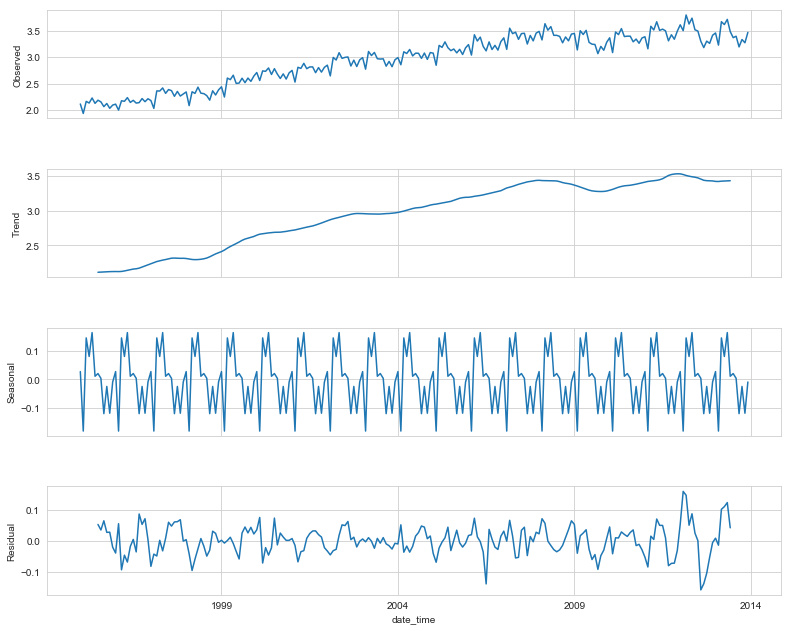

In [6]:
def naive_decompose(df, col, model):
    from statsmodels.tsa.seasonal import seasonal_decompose
    df.index = df['date_time'] # seasonal_decompose requires a datetime index
    series = df[col]
    results = seasonal_decompose(series, model=model)
    results.plot()
    ax=plt.gca()
    fig=plt.gcf()
    fig.set_size_inches(12,10)
    return results
rr = naive_decompose(df, 'Milk.Prod', model = 'additive')


We can see the trend and annual seasonal components clearly separated in the above plots.
Hence s=12

To further study the seasonality and order of ts, lets apply seasonal difference first and then (if necessary) apply first difference on the original ts.

In [7]:
def diff(df, col, col_out, periods):
    dfa = pd.DataFrame()
    dfa = df.copy()
    dfa[col_out] = df[col].diff(periods=periods)
    dfa = dfa.dropna() # dfa[col_out] has n-1 elements
    return dfa
df_diff = diff(df=df, col='Milk.Prod', col_out = 'Milk.Diff', periods=12)
df_diff.head()

,Month,Year,Milk.Prod,day,date_time,Milk.Diff
date_time,,,,,,
1996-01-01,1,1996,2.109,1,1996-01-01,-0.003
1996-02-01,2,1996,1.996,1,1996-02-01,0.064
1996-03-01,3,1996,2.173,1,1996-03-01,0.011
1996-04-01,4,1996,2.163,1,1996-04-01,0.033
1996-05-01,5,1996,2.233,1,1996-05-01,0.006


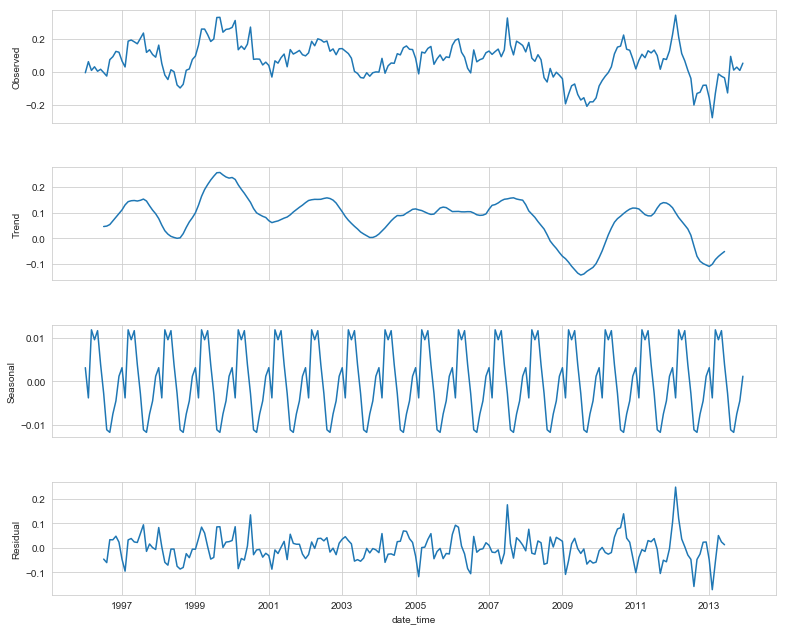

In [8]:
# check the decomposition of seasonal difference ts
naive_decompose(df_diff, 'Milk.Diff', model = 'additive')

Seasonality component is a lot smaller (an order less) than earlier. 

Still some trend can be seen. Lets apply first difference

In [9]:
df_diff1 = diff(df=df_diff, col='Milk.Diff', col_out = 'Milk.Diff1', periods=1)
df_diff1.head()

,Month,Year,Milk.Prod,day,date_time,Milk.Diff,Milk.Diff1
date_time,,,,,,,
1996-02-01,2,1996,1.996,1,1996-02-01,0.064,0.067
1996-03-01,3,1996,2.173,1,1996-03-01,0.011,-0.053
1996-04-01,4,1996,2.163,1,1996-04-01,0.033,0.022
1996-05-01,5,1996,2.233,1,1996-05-01,0.006,-0.027
1996-06-01,6,1996,2.142,1,1996-06-01,0.018,0.012


count    215.000000
mean       0.000270
std        0.062691
min       -0.195000
25%       -0.029500
50%        0.001000
75%        0.033000
max        0.221000
Name: Milk.Diff1, dtype: float64

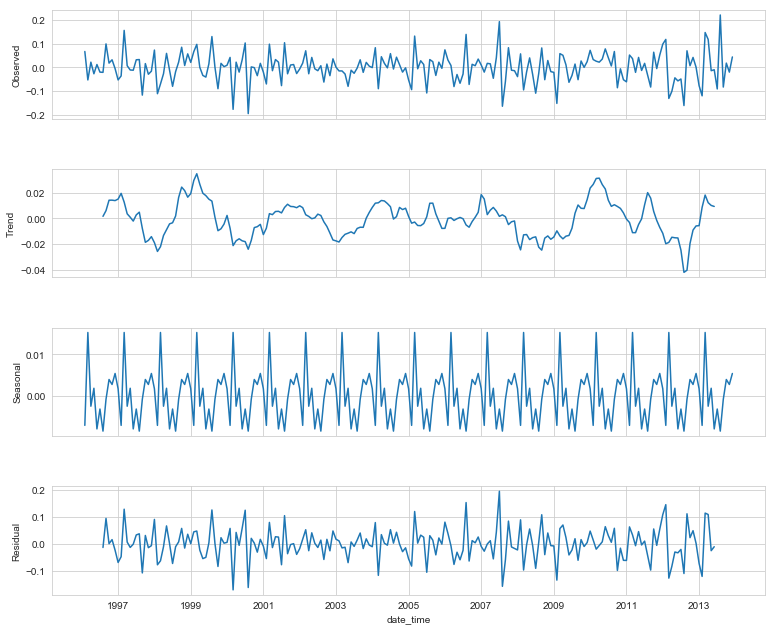

In [10]:
naive_decompose(df_diff1, 'Milk.Diff1', model='additive')
df_diff1['Milk.Diff1'].describe()

The trend looks much reduced now. Now lets examine the acf and pacf plots of the difference series.

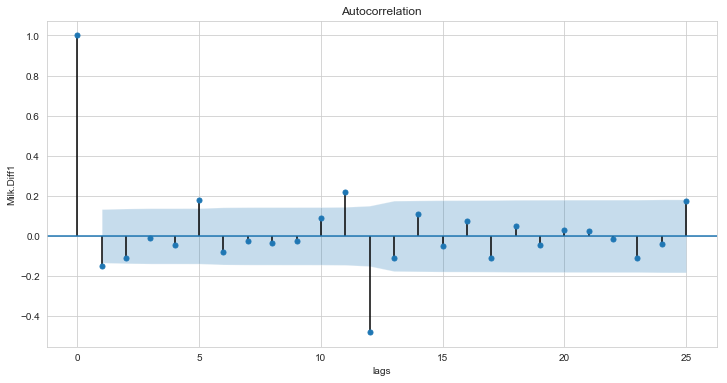

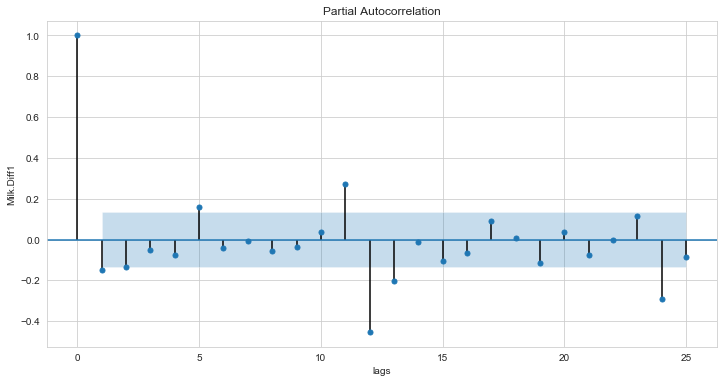

In [11]:
def acf(df, col):
    from statsmodels.graphics.tsaplots import plot_acf
    fig = plt.figure(figsize=(12,6))
    fig.clf()
    ax = fig.gca()
    plot_acf(df[col], ax=ax, lags=25, alpha=.05, fft=True, unbiased=True)
    ax.set_xlabel('lags')
    ax.set_ylabel(col)
    return
def pacf(df, col):
    from statsmodels.graphics.tsaplots import plot_pacf
    fig = plt.figure(figsize=(12,6))
    fig.clf()
    ax = fig.gca()
    plot_pacf(df[col], ax=ax, lags=25, alpha=.05)
    ax.set_xlabel('lags')
    ax.set_ylabel(col)
    return
acf(df_diff1, 'Milk.Diff1')
pacf(df_diff1, 'Milk.Diff1')

There is no spike at low lags, so most likely no non-seasonal MA or AR. ACF shows spike at near 12 and PACF shows skike at 12, 24. So, MA(1) seasonal is expected. 

So, we should start with SARIMAX(0,1,0)(0,1,1)12

Or, lets do a grid search and verify the order of best model. Parameters combinations in an assumed range (0,2) are created in this step

In [15]:
def sarimax(s, order, seasonal_order):
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    mod_dict = {}
    model = SARIMAX(s, order=order, seasonal_order=seasonal_order, 
                   enforce_stationarity = False,
                   enforce_invertibility = False)
    return model.fit(maxiter=250) #max iteraion to remove convergance error
    

In [16]:
# print(df['Milk.Prod'].index.freq)
# print(df['Milk.Prod'].index.inferred_freq)

Grid Search to find the best parameters. Sort models by aic values.

In [17]:
import itertools
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

# create series and DateTimeIndex
s = pd.Series()
s = df['Milk.Prod']
s.index = pd.DatetimeIndex(df.index.values, freq=df.index.inferred_freq)

dict = {} #dictionary for storing order info and aic values
for order in pdq:
    for seas_order in seasonal_pdq:
        model = sarimax(s, order=order, seasonal_order=seas_order)
        params = f'{order} - {seas_order}'
        dict[params] = model.aic

C:\ProgramData\Anaconda3\envs\PythonData\lib\site-packages\statsmodels\tsa\statespace\representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
C:\ProgramData\Anaconda3\envs\PythonData\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\envs\PythonData\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\envs\PythonData\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Li

In [18]:
from operator import itemgetter
dict_sorted = sorted(dict.items(), key=itemgetter(1))
dict_sorted

[('(1, 0, 0) - (1, 0, 1, 12)', -685.9300455875091),
 ('(1, 0, 1) - (1, 0, 1, 12)', -682.0665322004534),
 ('(0, 1, 0) - (1, 0, 1, 12)', -681.414851774973),
 ('(1, 1, 0) - (1, 0, 1, 12)', -680.3947072709304),
 ('(1, 1, 1) - (1, 0, 1, 12)', -679.1637309338855),
 ('(0, 1, 1) - (1, 0, 1, 12)', -678.0345144429835),
 ('(1, 1, 1) - (0, 1, 1, 12)', -634.4703802540863),
 ('(1, 0, 0) - (0, 1, 1, 12)', -634.3127682695755),
 ('(0, 1, 1) - (0, 1, 1, 12)', -633.7110052735135),
 ('(1, 0, 1) - (0, 1, 1, 12)', -631.8997842673884),
 ('(1, 1, 0) - (0, 1, 1, 12)', -631.4550348387671),
 ('(0, 1, 0) - (0, 1, 1, 12)', -630.2315962724387),
 ('(0, 1, 1) - (1, 1, 1, 12)', -628.2322203461738),
 ('(1, 1, 1) - (1, 1, 1, 12)', -628.0964776514477),
 ('(1, 0, 0) - (1, 1, 1, 12)', -627.5305200120192),
 ('(1, 0, 1) - (1, 1, 1, 12)', -626.2824642142896),
 ('(1, 1, 0) - (1, 1, 1, 12)', -625.6898569969235),
 ('(0, 1, 0) - (1, 1, 1, 12)', -623.1797780037733),
 ('(1, 0, 1) - (1, 1, 0, 12)', -602.7147985601573),
 ('(0, 1, 1) 

So let's use the SARIMA model of order - {(1, 0, 0) - (1, 0, 1, 12)}, since it yeilds the lowest aic value of -685.9

In [23]:
order = (1,0,0)
results = sarimax(s, order=(1,0,0), seasonal_order=(1,0,1,12))
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9598      0.022     43.113      0.000       0.916       1.003
ar.S.L12       1.0239      0.004    247.659      0.000       1.016       1.032
ma.S.L12      -0.8321      0.054    -15.298      0.000      -0.939      -0.725
sigma2         0.0022      0.000     14.440      0.000       0.002       0.002


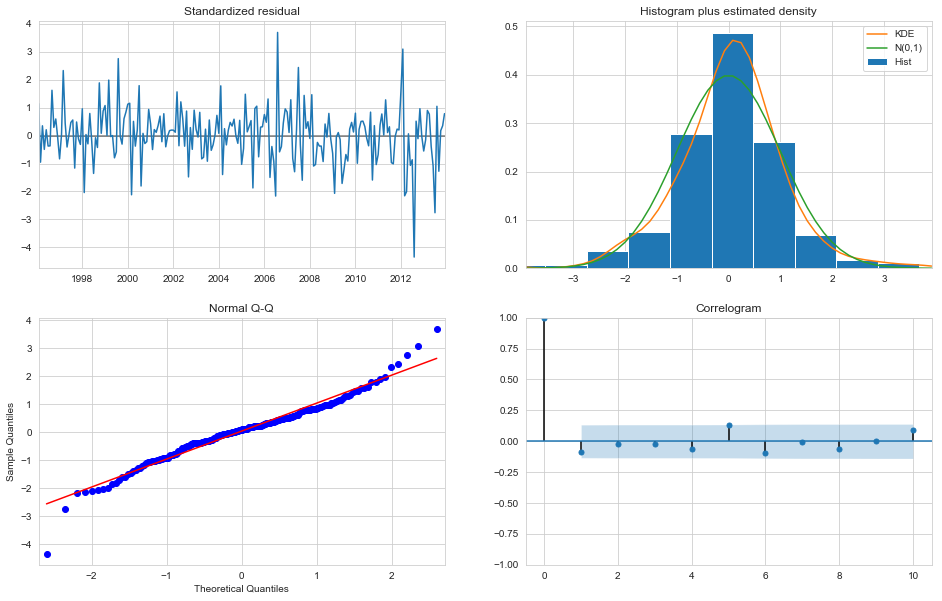

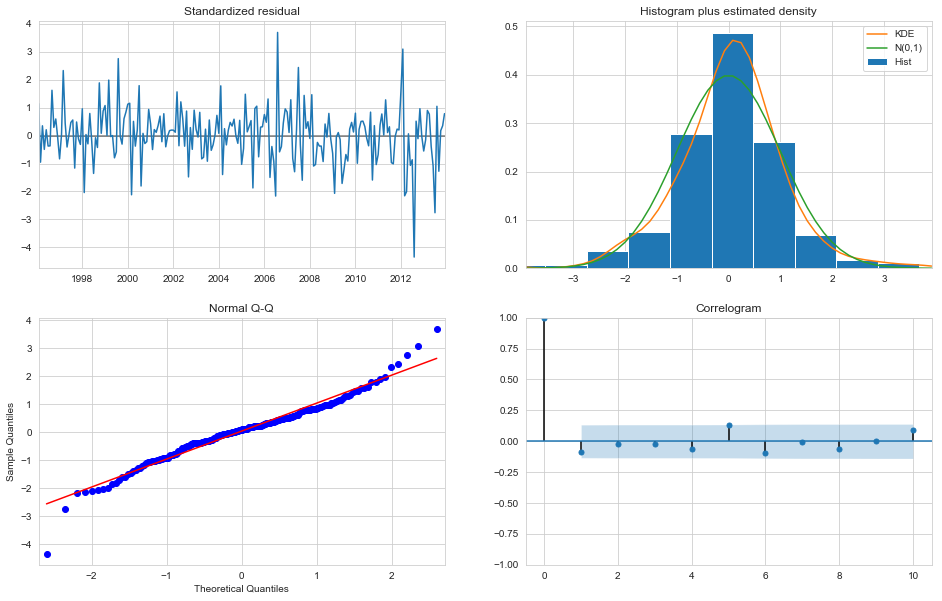

In [24]:
results.plot_diagnostics(figsize=(16,10))

* Model residuals are normally distributed around zero mean
* ACF shows stationary residual ts

Hence, the model looks to be a good fit to the original timeseries. 

## Forecasts

In [25]:
forecasts = results.get_prediction(start=pd.to_datetime('2010-01-01'), dynamic=False)
forecasts_ci = results.conf_int()

In [28]:
forecasts

In [ ]:
pred = results.get_prediction(start=pd.to_datetime('2010-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()
